# Auxiliary tests notebook

This notebook contains code for auxiliary tests.

Copyright (C) 2020  Andrew Sonta, Rishee K. Jain

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import os
import copy
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%load_ext rpy2.ipython
import networkx as nx
import src.__init__ as init
timestep = init.TIME_STEP
timesteps = int(1440/timestep)

In [2]:
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0)

In [3]:
from importlib import reload
import src.interaction_model as im
im = reload(im)
# Data segment 1: 08-09 to 10-09 (61 days) -- all occupants
overlaps1, similarities1 = im.interaction_matrix(classified['2018-08-09':'2018-10-09'])
# Data segment 2: 10-09 to 04-24 (197 days) -- occupant 10 gone
overlaps2, similarities2 = im.interaction_matrix(classified['2018-10-09':'2019-04-24'])
# Data segment 3: 04-24 to 06-17 (54 days) -- occupant 5 gone, occupant 10 gone
overlaps3, similarities3 = im.interaction_matrix(classified['2019-04-24':'2019-06-17'])
# Data segment 4: 06-17 to 08-09 (53 days) -- occupants 5 gone, occupant 10 in space 13, occupant 13 gone 
overlaps4, similarities4 = im.interaction_matrix(classified['2019-06-17':'2019-08-09'])

In [4]:
# Adjust similarity calculations for different data segments
overlaps1_2 = (overlaps1 + overlaps2)/(61+197)
overlaps1_2[9,:,:] = overlaps1[9,:,:]/61
overlaps1_2[:,9,:] = overlaps1[:,9,:]/61
overlaps1_3 = (overlaps1_2*(61+197) + overlaps3)/(61+197+54)
overlaps1_3[4,:,:] = overlaps1_2[4,:,:]
overlaps1_3[:,4,:] = overlaps1_2[:,4,:]
overlaps1_3[9,:,:] = overlaps1_2[9,:,:]
overlaps1_3[:,9,:] = overlaps1_2[:,9,:]
overlaps = (overlaps1_3*(61+197+54) + overlaps4)/365
overlaps[4,:,:] = overlaps1_2[4,:,:]
overlaps[:,4,:] = overlaps1_2[:,4,:]
overlaps[:,9,:] = (overlaps[:,9,:]*(61+197+54) + overlaps4[:,12,:])/365
overlaps[9,:,:] = (overlaps1_3[9,:,:]*(61+197+54) + overlaps4[12,:,:])/365
overlaps[:,12,:] = overlaps1_3[:,12,:]
overlaps[12,:,:] = overlaps1_3[12,:,:]
overlaps = overlaps[0:18,0:18,:]

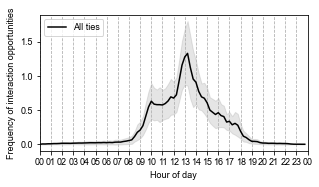

In [13]:
import matplotlib.dates as mdates

font_path = 'MyriadPro-Regular.otf'
prop = fm.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = prop.get_name()

font = {'family' : 'Arial',
        'size'   : 9}
matplotlib.rc('font', **font)

x = pd.date_range('00:00:00', '23:59:59',freq='15T')
fig, ax = plt.subplots(figsize=(4.8,2.5)) 

timeoverlaps = np.sum(overlaps, axis=1)
std = np.std(timeoverlaps, axis=0)
toplot = list(np.mean(timeoverlaps, axis=0))
#timeoverlaps = np.sum(timeoverlaps, axis=0)
ax.plot(x, toplot, color='k', label='All ties')
plt.fill_between(x, toplot - std, toplot + std, color='gray', alpha=0.2)

ax.grid(True, which='both', axis='x', linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H')) 
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.set_xlim(x[0], x[95]+1*x.freq)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Frequency of interaction opportunities')
ax.legend(loc='upper left')
#plt.gcf().autofmt_xdate()
#plt.show()
plt.savefig('overlaps.pdf', dpi=300, bbox_inches = 'tight')

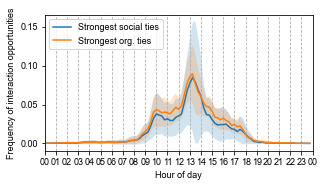

In [12]:
import matplotlib.dates as mdates
font = {'family' : 'Arial',
        'size'   : 9}
matplotlib.rc('font', **font)

x = pd.date_range('00:00:00', '23:59:59',freq='15T')
fig, ax = plt.subplots(figsize=(4.8,2.5)) 

social = np.genfromtxt('ground/survey-updated/berkeley-social-adj.csv', delimiter=',', dtype=float, skip_header=1, filling_values=0)
social = social[:,1:]

strongest_social = np.zeros((len(social),timesteps))
for occ in range(0,len(social)):
    strong = np.argwhere(social[occ] == np.amax(social[occ]))
    strong = strong.flatten().tolist()
    if len(strong)==len(social): strong = []
    strong_overlaps = np.zeros((1,timesteps))
    for tie in strong:
        strong_overlaps += overlaps[occ][tie][:]
    if len(strong) != 0: strongest_social[occ] = strong_overlaps/len(strong)

toplot = list(np.mean(strongest_social, axis=0))
std = np.std(strongest_social, axis=0)
ax.plot(x, toplot, label='Strongest social ties')
ax.fill_between(x, toplot-std, toplot+std, alpha=0.2)

org = np.genfromtxt('data/graphs/org-adj.csv', delimiter=',', dtype=float, skip_header=1, filling_values=0)

strongest_org = np.zeros((len(org),timesteps))
for occ in range(0,len(org)):
    strong = np.argwhere(org[occ] == np.amax(org[occ]))
    strong = strong.flatten().tolist()
    if len(strong)==len(org): strong = []
    strong_overlaps = np.zeros((1,timesteps))
    for tie in strong:
        strong_overlaps += overlaps[occ][tie][:]
    if len(strong) != 0: strongest_org[occ] = strong_overlaps/len(strong)

toplot = list(np.mean(strongest_org, axis=0))
std = np.std(strongest_org, axis=0)
ax.plot(x, toplot, label='Strongest org. ties')
ax.fill_between(x, toplot-std, toplot+std, alpha=0.2)

ax.grid(True, which='both', axis='x', linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H')) 
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.set_xlim(x[0], x[95]+1*x.freq)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Frequency of interaction opportunities')
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.legend(loc='upper left')
#plt.gcf().autofmt_xdate()
#plt.show()
plt.savefig('overlaps_soc-vs-org.pdf', dpi=300, bbox_inches = 'tight')

In [7]:
classified_day= pd.read_csv('data/classified-berkeley.csv', index_col=0)
classified_day.index = pd.to_datetime(classified_day.index)
classified_day['Day'] = classified_day.index.day_name()
timeoverlaps_mon = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Monday'])[0], axis=1), axis=0))
timeoverlaps_tue = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Tuesday'])[0], axis=1), axis=0))
timeoverlaps_wed = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Wednesday'])[0], axis=1), axis=0))
timeoverlaps_thu = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Thursday'])[0], axis=1), axis=0))
timeoverlaps_fri = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Friday'])[0], axis=1), axis=0))
timeoverlaps_sat = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Saturday'])[0], axis=1), axis=0))
timeoverlaps_sun = list(np.mean(np.sum(im.interaction_matrix(classified_day.loc[classified_day['Day']=='Sunday'])[0], axis=1), axis=0))

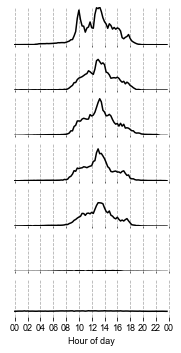

In [14]:
fig, ax =plt.subplots(7,1, figsize=(3, 5.7))
ax[0].plot(x, timeoverlaps_mon, color='k')
ax[1].plot(x, timeoverlaps_tue, color='k')
ax[2].plot(x, timeoverlaps_wed, color='k')
ax[3].plot(x, timeoverlaps_thu, color='k')
ax[4].plot(x, timeoverlaps_fri, color='k')
ax[5].plot(x, timeoverlaps_sat, color='k')
ax[6].plot(x, timeoverlaps_sun, color='k')
for i in range(7):
    ax[i].set_ylim(0,max(timeoverlaps_mon))
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H')) 
    ax[i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax[i].xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    ax[i].grid(True, which='both', axis='x', linestyle='--')
for i in range(6):
    ax[i].set_xticks([])
ax[6].set_xlabel('Hour of day')
ax[6].set_ylim(-20,max(timeoverlaps_mon))
plt.savefig('overlaps_days.pdf', dpi=300, bbox_inches = 'tight')

### Single instance of social/organizational tie difference

/Users/andrewsonta/Documents/Stanford/Research/occupant-network/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()


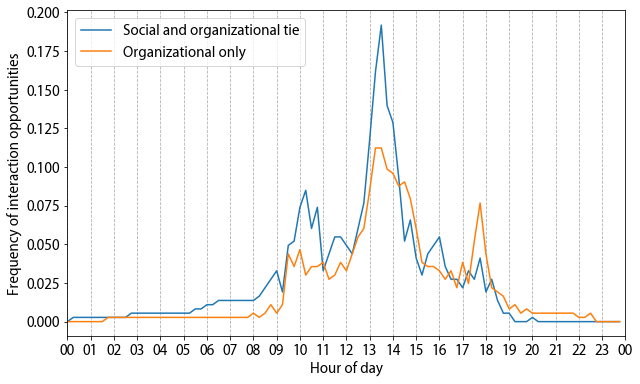

In [155]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax.plot(x, overlaps[6][11][:] , label='Social and organizational tie')
ax.plot(x, overlaps[1][8][:], label='Organizational only')
timeoverlaps = np.sum(overlaps, axis=1)
toplot = list(np.mean(timeoverlaps, axis=0))
#ax.plot(x, toplot, color='k')
ax.grid(True, which='both', axis='x', linestyle='--')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H')) 
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.set_xlim(x[0], x[95]+1)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Frequency of interaction opportunities')
ax.legend(loc='upper left')
plt.show()

### Simple lunchtime test using Interaction Model without the Jaccard weighting [Note: not in paper]

In [120]:
totaloverlaps = np.sum(overlaps[:,:], axis=2)
totaloverlaps_lunch = np.sum(overlaps[:,:,np.r_[0:48,56:96]], axis=2)
totaloverlaps_work = np.sum(overlaps[:,:,np.r_[28:48,56:76]], axis=2)
interaction_lunch_adj = totaloverlaps_lunch[0:18,0:18]
interaction_work_adj = totaloverlaps_work[0:18,0:18]

%Rpush totaloverlaps
%Rpush interaction_lunch_adj
%Rpush interaction_work_adj

In [87]:
write.csv(interaction_lunch_adj,'data/graphs/interaction-lunch-adj.csv', row.names=FALSE)
write.csv(interaction_work_adj,'data/graphs/interaction-work-adj.csv', row.names=FALSE)

In [90]:
%%R
interaction_adj = array(as.matrix(read.csv('data/graphs/interaction-adj.csv')), c(18,18))
interaction_lunch_adj = array(as.matrix(read.csv('data/graphs/interaction-lunch-adj.csv')), c(18,18))
interaction_work_adj = array(as.matrix(read.csv('data/graphs/interaction-work-adj.csv')), c(18,18))
info_adj = array(as.matrix(read.csv('data/graphs/info-adj.csv')), c(18,18))
prob_adj = array(as.matrix(read.csv('data/graphs/prob-adj.csv')), c(18,18))
support_adj = array(as.matrix(read.csv('data/graphs/support-adj.csv')), c(18,18))
socialnorm_adj = array(as.matrix(read.csv('data/graphs/socialnorm-adj.csv')), c(18,18))
org_adj = array(as.matrix(read.csv('data/graphs/org-adj.csv')), c(18,18))
ground_adj = array(as.matrix(read.csv('data/graphs/ground-adj.csv')), c(18,18))

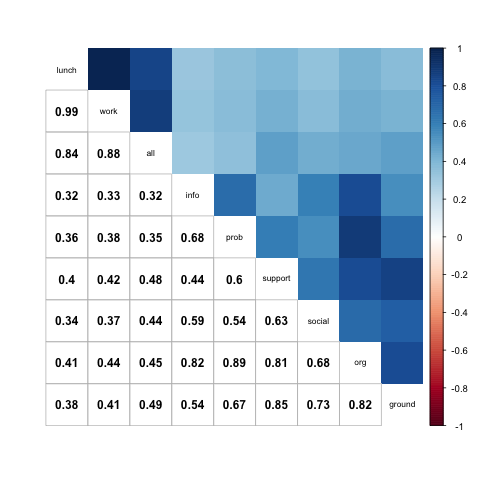

In [93]:
%%R
library(sna)
library(corrplot)
graphs2 = list(interaction_lunch_adj, interaction_work_adj, interaction_adj, info_adj, prob_adj, support_adj, socialnorm_adj, org_adj, ground_adj)
graphs2[is.na(graphs2)] <- 0
gcors2 <- gcor(graphs2)
rownames(gcors2) <- c('lunch','work','all','info','prob','support','social','org','ground')
colnames(gcors2) <- c('lunch','work','all','info','prob','support','social','org','ground')
#png(width=1800, height=1800, res=300, file='cor2.png')
corrplot.mixed(gcors2, lower='number', lower.col='black', upper='shade', tl.col='black', tl.cex=.7)